In [152]:
import csv
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
import matplotlib.pyplot as plt
from pywt import wavedec

In [153]:
csv_uri = '../Preprocessing/db1/data_MfccDwtRmsCqtdb1L5.csv'
data = pd.read_csv(csv_uri)
data.head()


,filename,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,cqt52,cqt53,cqt54,cqt55,cqt56,cqt57,cqt58,cqt59,cqt60,label
0,../data/DWT_NEW/MVP/New_MVP_062.wav,88.547943,-34.731178,17.439774,3.966827,-17.346939,18.881588,-17.580509,8.225138,2.163004,...,0.162481,0.128590,0.253865,0.286246,0.232347,0.166034,0.149659,0.175466,0.264108,MVP
1,../data/DWT_NEW/MVP/New_MVP_109.wav,130.248093,-18.175362,-7.527256,-1.821126,-0.783999,9.139212,-30.255112,-18.019503,-3.269579,...,0.272742,0.214996,0.163759,0.185034,0.284470,0.427768,0.583855,0.714654,0.804361,MVP
2,../data/DWT_NEW/MVP/New_MVP_009.wav,68.611404,-30.707958,43.091286,-5.395578,-31.639091,25.854515,-19.372128,12.241970,-3.681171,...,0.268128,0.329467,0.240955,0.215759,0.290983,0.327005,0.241768,0.163038,0.190981,MVP
3,../data/DWT_NEW/MVP/New_MVP_177.wav,124.010841,-26.582684,4.632347,-2.877658,-2.610994,1.804899,-2.408908,5.523919,-0.094534,...,0.535192,0.555842,0.328036,0.101016,0.362609,0.401901,0.259996,0.146674,0.301535,MVP
4,../data/DWT_NEW/MVP/New_MVP_069.wav,87.647217,-33.906952,0.952698,-12.743137,-30.600828,29.831501,-26.453606,7.694873,0.659293,...,0.448852,0.387767,0.466638,0.528683,0.326940,0.347330,0.452033,0.500666,0.408247,MVP


In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Columns: 103 entries, filename to label
dtypes: float64(101), object(2)
memory usage: 724.3+ KB


In [155]:
# scaler = StandardScaler()
X = data.drop(['label', 'filename'], axis=1)
# X = scaler.fit_transform(X)
# X = np.reshape(X, (-1, X.shape[0], X.shape[1], 1))
y = data.iloc[:, -1]

In [156]:
X.shape

(900, 101)

In [157]:
y.head()

0    MVP
1    MVP
2    MVP
3    MVP
4    MVP
Name: label, dtype: object

In [158]:
X

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,cqt51,cqt52,cqt53,cqt54,cqt55,cqt56,cqt57,cqt58,cqt59,cqt60
0,88.547943,-34.731178,17.439774,3.966827,-17.346939,18.881588,-17.580509,8.225138,2.163004,-6.991869,...,0.080291,0.162481,0.128590,0.253865,0.286246,0.232347,0.166034,0.149659,0.175466,0.264108
1,130.248093,-18.175362,-7.527256,-1.821126,-0.783999,9.139212,-30.255112,-18.019503,-3.269579,6.034618,...,0.317061,0.272742,0.214996,0.163759,0.185034,0.284470,0.427768,0.583855,0.714654,0.804361
2,68.611404,-30.707958,43.091286,-5.395578,-31.639091,25.854515,-19.372128,12.241970,-3.681171,-0.359709,...,0.276001,0.268128,0.329467,0.240955,0.215759,0.290983,0.327005,0.241768,0.163038,0.190981
3,124.010841,-26.582684,4.632347,-2.877658,-2.610994,1.804899,-2.408908,5.523919,-0.094534,6.949768,...,0.438422,0.535192,0.555842,0.328036,0.101016,0.362609,0.401901,0.259996,0.146674,0.301535
4,87.647217,-33.906952,0.952698,-12.743137,-30.600828,29.831501,-26.453606,7.694873,0.659293,-6.993608,...,0.261029,0.448852,0.387767,0.466638,0.528683,0.326940,0.347330,0.452033,0.500666,0.408247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,164.662933,18.447191,2.258896,8.766978,-1.978719,3.208094,-4.836560,3.958564,3.583583,5.426387,...,0.497254,0.439649,0.530119,0.586929,0.559389,0.487167,0.422263,0.381106,0.419188,0.415870
896,67.973389,-77.092560,20.854347,3.179512,-0.732732,8.882547,7.136349,-12.011120,-2.628152,0.461927,...,0.065206,0.115020,0.143318,0.126561,0.091858,0.099164,0.161563,0.226875,0.217660,0.115195
897,199.847290,2.052064,10.958324,2.982365,-4.694814,-5.742703,-17.959709,14.001516,15.751791,3.562183,...,1.368673,1.202957,1.253259,1.266183,1.044170,0.663657,0.303062,0.444658,0.695424,0.751368
898,98.552094,-53.283867,39.570427,1.234147,-11.877034,0.053518,-1.286855,2.424939,10.428095,4.580007,...,0.326343,0.317389,0.265434,0.206924,0.172030,0.152062,0.127119,0.129681,0.161393,0.161473


In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [160]:
y_test.shape

(180,)

In [161]:
X_train.shape

(720, 101)

In [162]:
X_train

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,cqt51,cqt52,cqt53,cqt54,cqt55,cqt56,cqt57,cqt58,cqt59,cqt60
10,4.314944,-80.155304,31.539179,-15.789383,12.516445,-6.611809,2.372676,-6.058306,-3.496922,-4.178765,...,0.018976,0.024869,0.022892,0.014639,0.024999,0.023980,0.013636,0.017384,0.026579,0.022777
334,54.503723,-41.367424,48.399117,-9.767862,-23.927776,14.609686,-10.254643,6.549664,0.189328,1.122744,...,0.212671,0.213660,0.200182,0.181743,0.152893,0.125272,0.146561,0.155583,0.139843,0.123858
244,55.966881,-37.387817,47.005547,-0.751225,-9.511966,3.952195,0.353659,6.933780,-6.587204,4.317513,...,0.051018,0.057589,0.054120,0.049960,0.049560,0.049883,0.040081,0.034032,0.030285,0.027783
678,129.956497,-27.350931,-3.110487,5.861757,5.723415,4.147360,13.904932,2.406283,-0.162421,-3.731496,...,0.212201,0.284335,0.271481,0.209435,0.272691,0.277367,0.247612,0.198224,0.185756,0.132383
306,38.863163,-55.595146,45.313419,-8.766414,-24.194538,13.574966,-8.415053,10.158276,-9.115362,2.618633,...,0.106329,0.126158,0.112372,0.127090,0.118933,0.125747,0.115665,0.107891,0.104901,0.110099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,5.145700,-65.987762,40.869423,-18.713455,21.685717,-10.311221,9.841274,-7.008872,-5.599904,-0.157352,...,0.054428,0.023639,0.016446,0.042021,0.044275,0.026853,0.028605,0.036752,0.025814,0.021942
270,63.545021,-48.544891,27.680458,-4.523205,-5.682001,5.286124,-1.581363,-0.671593,-2.775605,3.084220,...,0.060647,0.057623,0.065459,0.061655,0.049629,0.042573,0.032021,0.018934,0.026061,0.031315
860,120.980637,-49.460346,28.065496,-4.179470,9.534807,-2.758196,-6.629617,-3.639332,3.070858,-0.821289,...,0.309850,0.278900,0.238843,0.200179,0.174700,0.175035,0.176176,0.149111,0.138299,0.227936
435,30.062765,-47.433411,51.785614,6.403006,-54.266167,11.053203,-25.836227,15.351446,-2.097059,-6.517249,...,0.277985,0.211103,0.228536,0.216290,0.177742,0.165194,0.128024,0.108679,0.084226,0.059343


In [163]:
lb = LabelEncoder()
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print(y_test.shape)
y_test = tf.keras.utils.to_categorical(lb.fit_transform(y_test))
y_train = tf.keras.utils.to_categorical(lb.fit_transform(y_train))
print(X_train.shape)
print(X_test.shape)



(180,)
(720, 101, 1)
(180, 101, 1)


In [164]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [165]:
# make RNN model
def build_model():
    model = models.Sequential(
        [
            layers.SimpleRNN(64,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
            layers.Dense(32, activation="relu"),

            layers.Flatten(),
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),

            layers.BatchNormalization(),

            layers.Dense(5, activation="softmax"),
            # layers.SimpleRNN(64,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
            # layers.Dense(32, activation="relu", activity_regularizer=tf.keras.regularizers.l2(1e-4)),

            # layers.Flatten(),
            # layers.Dense(64, activation="relu", activity_regularizer=tf.keras.regularizers.l2(1e-4)),
            # layers.Dense(32, activation="relu", activity_regularizer=tf.keras.regularizers.l2(1e-4)),

            # layers.Dense(5, activation="softmax"),
        ]
    )

    return model

In [166]:
model = build_model()
model.summary()
model.save('../modelh5/model_rnn_nontuning.h5')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 101, 64)           4224      
                                                                 
 dense_28 (Dense)            (None, 101, 32)           2080      
                                                                 
 flatten_7 (Flatten)         (None, 3232)              0         
                                                                 
 dense_29 (Dense)            (None, 64)                206912    
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_4 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                      

/home/rafli/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [167]:
optimazer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimazer, loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
# history = model.fit(X_train, y_train, epochs=35, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50


23/23 [==============================] - 2s 25ms/step - loss: 1.2515 - acc: 0.5556 - val_loss: 1.3824 - val_acc: 0.4222
Epoch 2/50
23/23 [==============================] - 0s 15ms/step - loss: 0.7414 - acc: 0.7458 - val_loss: 1.2666 - val_acc: 0.5556
Epoch 3/50
23/23 [==============================] - 0s 15ms/step - loss: 0.5966 - acc: 0.8125 - val_loss: 1.1722 - val_acc: 0.7000
Epoch 4/50
23/23 [==============================] - 0s 15ms/step - loss: 0.5051 - acc: 0.8556 - val_loss: 1.0824 - val_acc: 0.7778
Epoch 5/50
23/23 [==============================] - 0s 15ms/step - loss: 0.4417 - acc: 0.8750 - val_loss: 1.0015 - val_acc: 0.7778
Epoch 6/50
23/23 [==============================] - 0s 15ms/step - loss: 0.3880 - acc: 0.8889 - val_loss: 0.9244 - val_acc: 0.7944
Epoch 7/50
23/23 [==============================] - 0s 15ms/step - loss: 0.3608 - acc: 0.9208 - val_loss: 0.8474 - val_acc: 0.8278
Epoch 8/50
23/23 [==============================] - 0s 15ms/step - loss: 0.3165 - acc: 0.9403 

6/6 [==============================] - 0s 5ms/step - loss: 0.2527 - acc: 0.9222
Accuracy on test set is: 0.9222221970558167


Text(0, 0.5, 'Accuracy')

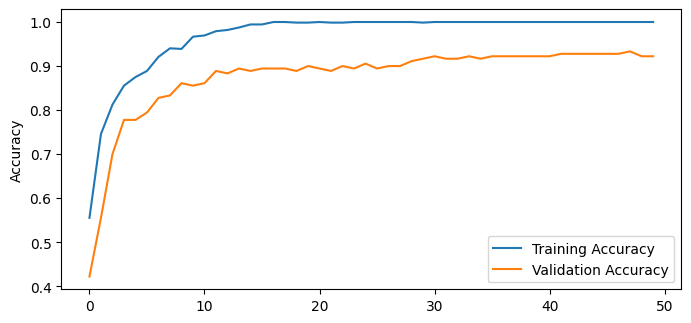

In [168]:
# evaluate model on test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy on test set is: {}".format(test_accuracy))


# plot accuracy/error for training and validation
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')

In [169]:
model_uri = "../modelh5/model_RNN.h5"
model.save(model_uri)

In [170]:
# confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_p = np.argmax(y_pred, axis=1)
y_t = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_t, y_p)
cm

6/6 [==============================] - 0s 5ms/step


array([[31,  2,  1,  1,  0],
       [ 1, 25,  2,  3,  0],
       [ 0,  0, 37,  0,  1],
       [ 1,  0,  2, 32,  0],
       [ 0,  0,  0,  0, 41]])

In [171]:
# classification_report
from sklearn.metrics import classification_report

print(classification_report(y_t, y_p))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91        35
           1       0.93      0.81      0.86        31
           2       0.88      0.97      0.93        38
           3       0.89      0.91      0.90        35
           4       0.98      1.00      0.99        41

    accuracy                           0.92       180
   macro avg       0.92      0.92      0.92       180
weighted avg       0.92      0.92      0.92       180



### Testing

In [172]:
new_model = tf.keras.models.load_model(model_uri)
new_model.summary()



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 101, 64)           4224      
                                                                 
 dense_28 (Dense)            (None, 101, 32)           2080      
                                                                 
 flatten_7 (Flatten)         (None, 3232)              0         
                                                                 
 dense_29 (Dense)            (None, 64)                206912    
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_4 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                      

In [173]:
import wave
import json
header = 'filename'
for i in range(1, 41):
    header += f' mfcc{i}'
header += ' rms'
for i in range(1, 61):
  header += f' cqt{i}'
header += ' label'
header = header.split()


def extract_mfcc(audiofile):
    file = open('test.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    y, sr = librosa.load(audiofile, mono=True, duration=3, sr=8000)
    coeffs = wavedec(y, 'db1', level=10)
    cA,cD10,cD9,cD8,cD7,cD6,cD5,cD4,cD3,cD2, cD1 = coeffs
    mfcc = librosa.feature.mfcc(y=cD5, sr=8000, n_mfcc=40, n_fft=2048, hop_length=512, n_mels=128)
    rms = librosa.feature.rms(y=cD5)[0]
    cqt = np.abs(librosa.cqt(y=cD5, sr=sr, n_bins=60)) 
    combined_features = np.concatenate((mfcc, rms.reshape(1, -1), cqt), axis=0)
    to_append = f'Signal'
    for e in combined_features:
        to_append += f' {np.mean(e.T, axis=0)}'
    file = open('test.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

def predict(audio):
    model = tf.keras.models.load_model(model_uri)
    extract_mfcc(audio)
    data = pd.read_csv('test.csv')
    df = data.drop(['label', 'filename'], axis=1)
    pred = model.predict(df)
    class_labels = ['AS', 'MR', 'MS', 'MVP', 'N']
    cek = np.argmax(pred[0])
    print(pred[0])
    print(cek)
    print(f'Predicted class: {class_labels[cek]}')

In [174]:
predict('../data/training/MVP/New_MVP_004.wav')

/home/rafli/anaconda3/envs/tf/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=640
  warnings.warn(
/home/rafli/anaconda3/envs/tf/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=320
  warnings.warn(
/home/rafli/anaconda3/envs/tf/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=160
  warnings.warn(
/home/rafli/anaconda3/envs/tf/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=80
  warnings.warn(
/home/rafli/anaconda3/envs/tf/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=40
  warnings.warn(


1/1 [==============================] - 0s 184ms/step
[5.4051769e-03 5.0802394e-03 5.5228127e-03 9.8300928e-01 9.8247454e-04]
3
Predicted class: MVP
